In [1]:
import os
import sys
import gin
import numpy as np
import pandas as pd
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.pyplot as plt
from ariadne.transformer.model import HFPerceiver
import ariadne.transformations  as trn
from ariadne.utils.model import get_checkpoint_path, weights_update
import torch
import seaborn as sns
import torch.nn.functional as f
%matplotlib notebook
%load_ext autoreload
%autoreload 2

Load data

In [2]:
params = {
                    "sep": '\s+',
                    #"nrows": 10000,
                    "encoding": 'utf-8',
                    "names":  ['event',  'x', 'y', 'z', 'station',
                               'track', 'px', 'py', 'pz', 'X0', 'Y0', 'Z0', 'label']
                 }
data = pd.read_csv(os.path.join('D:/','data','spd','100.tsv'), **params)

In [3]:
data.head()

,event,x,y,z,station,track,px,py,pz,X0,Y0,Z0,label
0,0,180.799105,200.552795,376.525837,1,0,398.316211,488.016028,893.314275,4.548372,15.333173,-6.456175,NaN
1,0,186.583368,207.609373,389.258520,2,0,396.673125,489.352511,893.314275,4.548372,15.333173,-6.456175,NaN
2,0,192.433301,214.586434,402.479373,3,0,395.025411,490.683576,893.314275,4.548372,15.333173,-6.456175,NaN
3,0,198.089138,221.773558,415.428823,4,0,393.373084,492.009212,893.314275,4.548372,15.333173,-6.456175,NaN
4,0,203.856039,228.829904,428.388976,5,0,391.716155,493.329405,893.314275,4.548372,15.333173,-6.456175,NaN


In [4]:
def visualize_simple_3d(data, axes=['x','y','z'], titleAx=['X', 'Y', 'Z'], title=None, scatter_params_true=None, scatter_params_false=None):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    if not scatter_params_true:
        scatter_params_true = {}
    if not scatter_params_false:
        scatter_params_true = {}
    true_els = data[data['track']!=-1]
    false_els = data[data['track']==-1]
    ax.scatter(true_els[axes[0]], true_els[axes[1]],true_els[axes[2]], **scatter_params_true)
    ax.scatter(false_els[axes[0]], false_els[axes[1]], false_els[axes[2]], **scatter_params_false)
    
    ax.set_xlabel(titleAx[0])
    ax.set_ylabel(titleAx[1])
    ax.set_zlabel(titleAx[2])
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

In [5]:
events = data.groupby('event')

Let's check how event is loaded

<IPython.core.display.Javascript object>


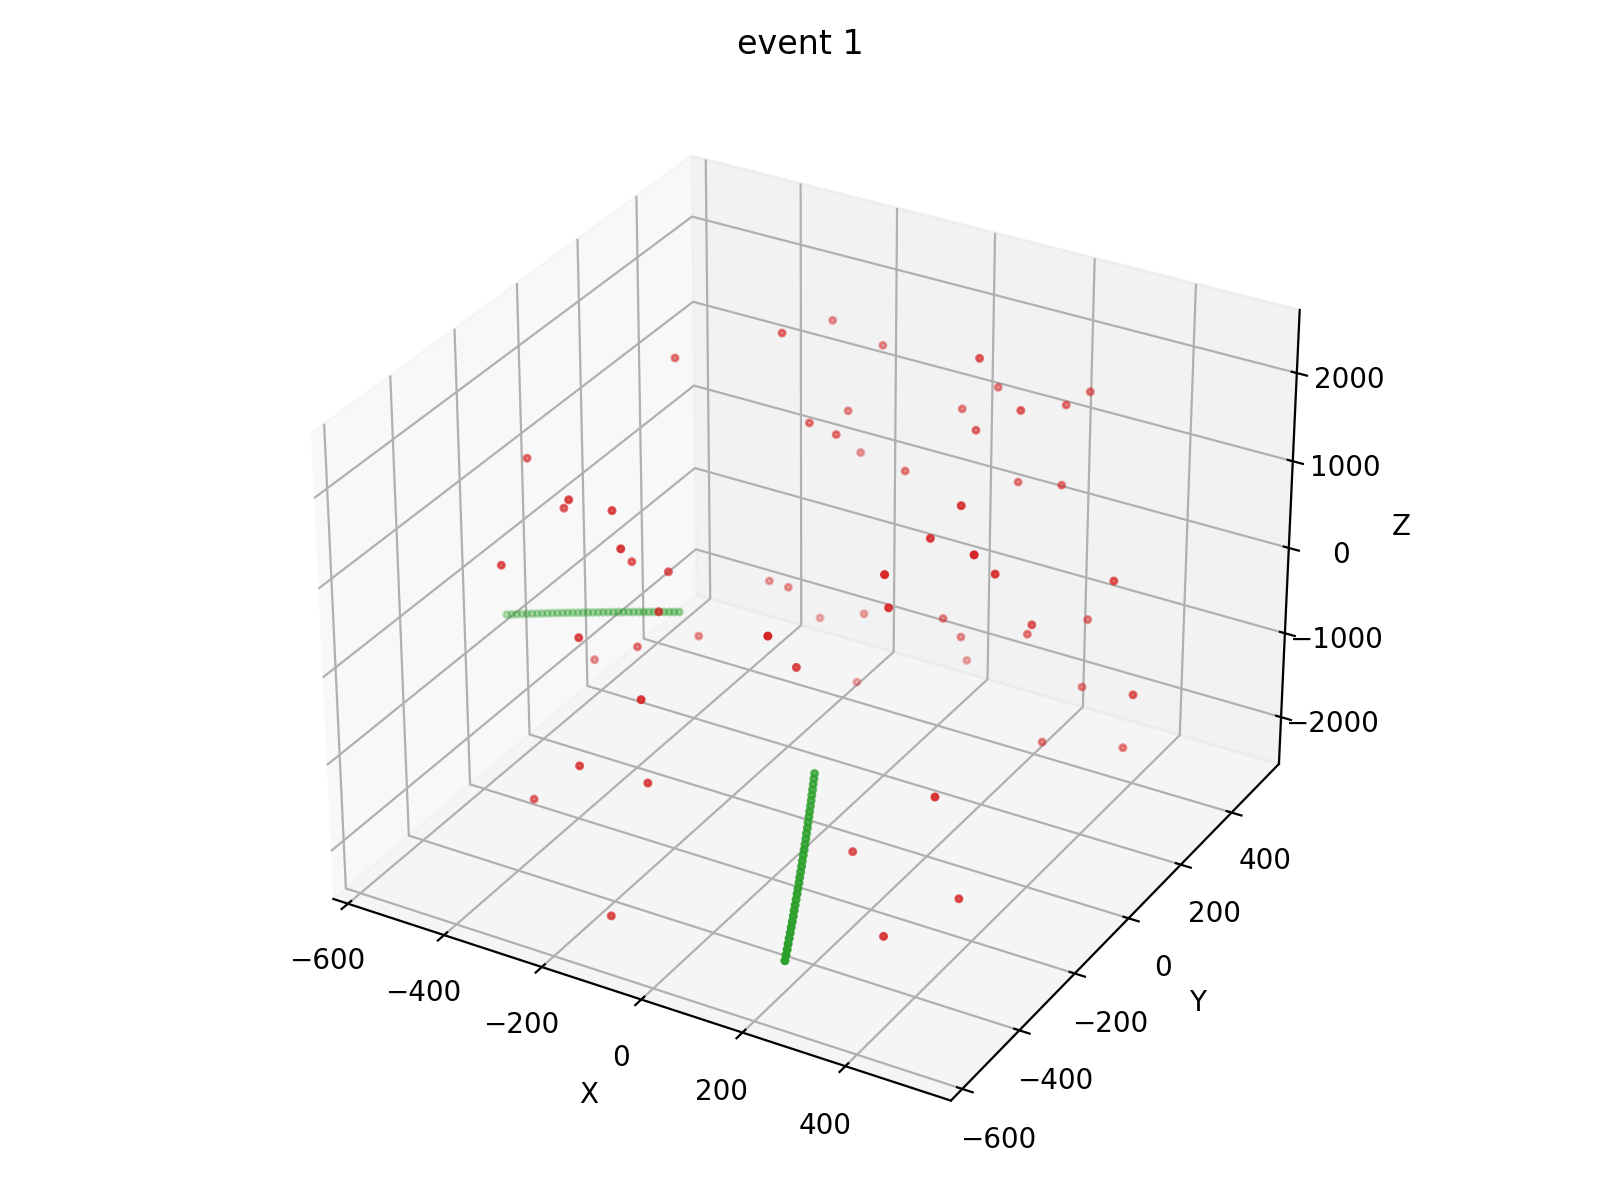

In [93]:
event_num = 6
visualize_simple_3d(data[data.event == event_num], title=f'event {event_num}', scatter_params_true={'c':'tab:green', 's':5}, scatter_params_false={'c':'tab:red', 's':5})

To change parameters of models (which are gin configurable) i enter interactive mode of gin (may be redundant)

In [6]:
gin.enter_interactive_mode()

Load model with basic parameters. Later check if model meets config file of checkpoint

In [7]:
model = HFPerceiver()
model = weights_update(model=model,
                           checkpoint=torch.load("D:\\projects\\ariadne\\lightning_logs\\HFPerceiver\\version_168\\epoch=36-step=37000.ckpt"))


Load event to test, perform necessary transformations.

In [8]:
event = data[data.event == 3]
transforms = trn.Compose([
    trn.ConstraintsNormalize(use_global_constraints = True, columns=('x', 'y', 'z'), constraints = {
    'x': [0., 600.], 'y': [0, 600.], 'z': [-2386., 2386.]
})])
event_t = transforms(event)

In [9]:
event_t

,event,x,y,z,station,track,px,py,pz,X0,Y0,Z0,label,index
833,3,-1.802307,-0.591337,-0.042090,1,0,-773.091449,429.505984,-585.588779,3.727026,0.905702,78.32408,NaN,833
834,3,-1.828770,-0.576484,-0.044695,2,0,-772.061271,431.355043,-585.588779,3.727026,0.905702,78.32408,NaN,834
835,3,-1.854892,-0.561408,-0.047087,3,0,-771.026624,433.201713,-585.588779,3.727026,0.905702,78.32408,NaN,835
836,3,-1.881304,-0.546433,-0.049742,4,0,-769.987513,435.045984,-585.588779,3.727026,0.905702,78.32408,NaN,836
837,3,-1.907722,-0.531416,-0.052231,5,0,-768.943942,436.887849,-585.588779,3.727026,0.905702,78.32408,NaN,837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,3,-2.407876,-1.448049,-0.883423,19,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,NaN,967
968,3,-1.484742,-0.032264,-0.630438,6,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,NaN,968
969,3,-1.369098,0.555837,0.734503,23,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,NaN,969
970,3,0.286031,-0.570417,0.080220,15,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,NaN,970


<IPython.core.display.Javascript object>


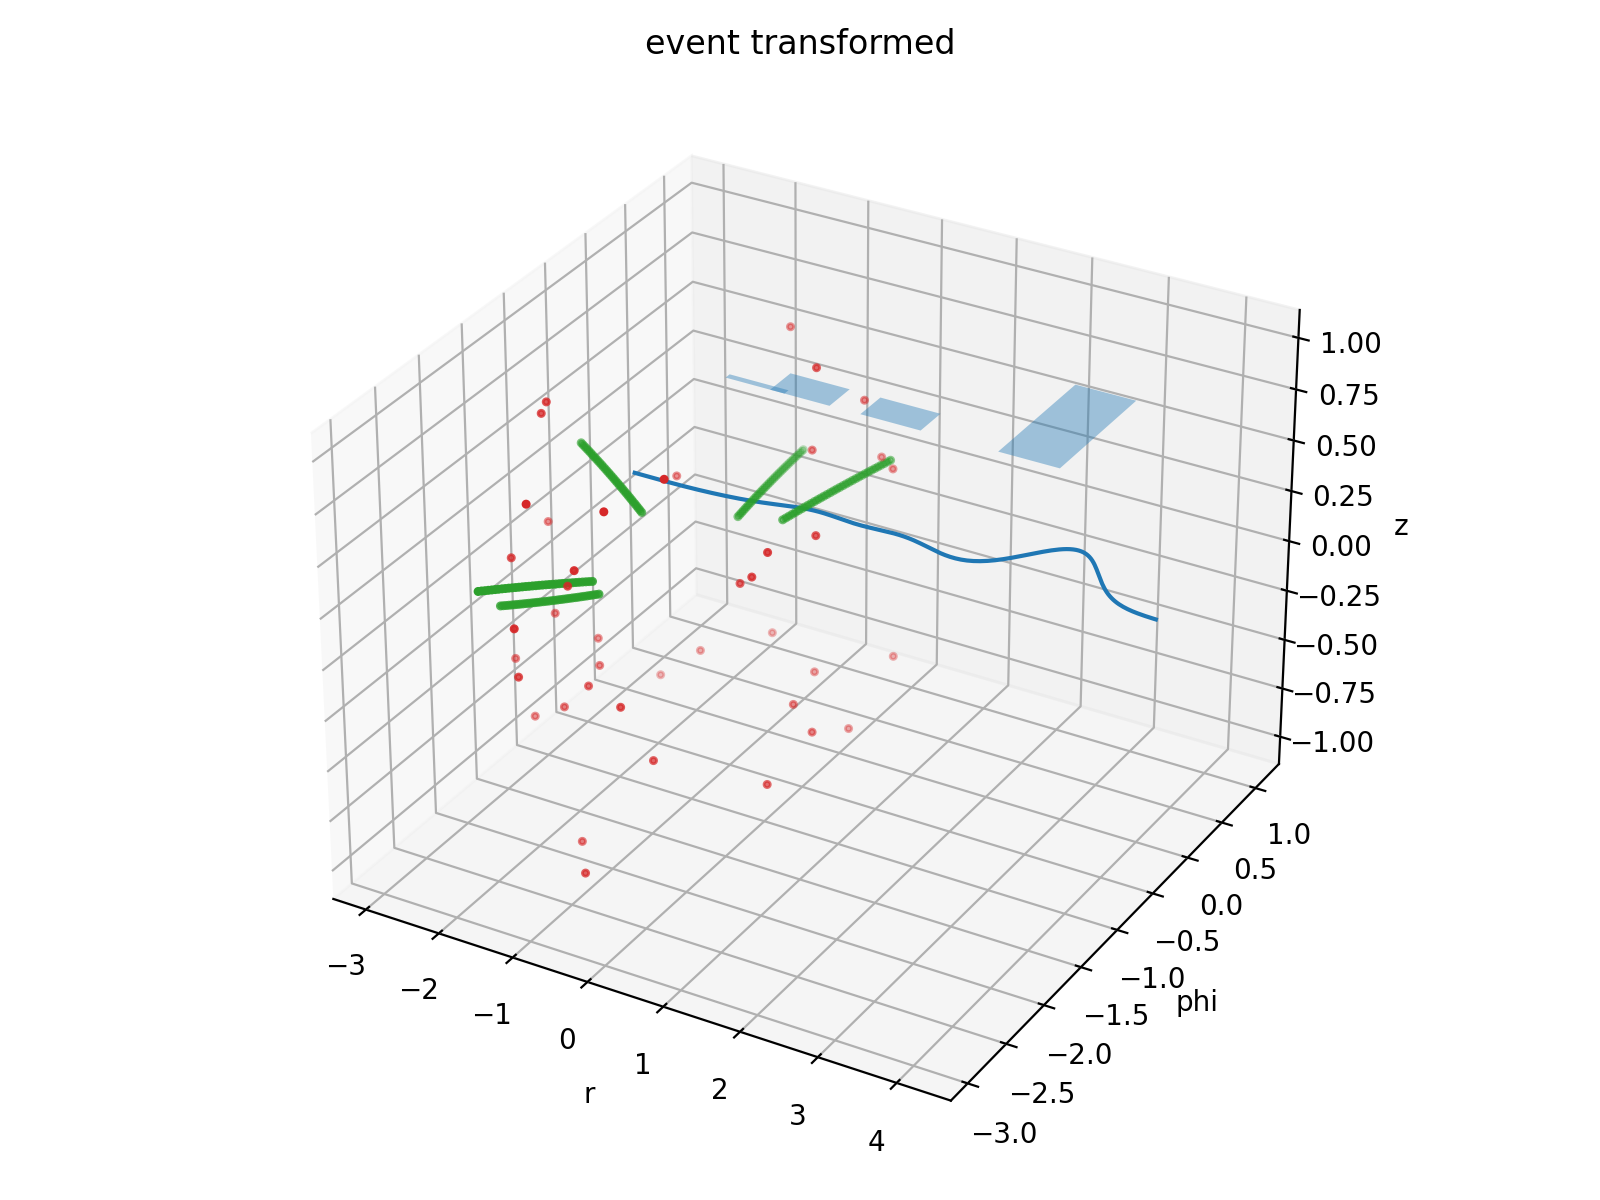

In [10]:
visualize_simple_3d(event_t, title='event transformed', scatter_params_true={'c':'tab:green', 's':5}, scatter_params_false={'c':'tab:red', 's':5}, axes=['x','y', 'z'], titleAx=['r', 'phi', 'z'])

Change event to prepare x and y. X must be in format [ N, C]. This may change later after i fix input dimensions in model

In [41]:
event_t = event_t.sample(frac = 1)

In [42]:
event_t

,event,x,y,z,station,track,px,py,pz,X0,Y0,Z0,label,index
855,3,-2.378192,-0.250720,-0.097937,23,0,-749.401342,469.620494,-585.588779,3.727026,0.905702,78.32408,NaN,855
847,3,-2.170156,-0.377816,-0.077572,15,0,-758.263761,455.172327,-585.588779,3.727026,0.905702,78.32408,NaN,847
898,3,-0.824299,-2.803201,-0.018428,31,1,-33.657677,-304.669800,-68.450992,3.727026,0.905702,78.32408,NaN,898
918,3,0.488894,-1.238298,-0.683825,20,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,NaN,918
909,3,-2.532374,-0.152792,0.935703,28,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,NaN,909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,3,-1.933894,-0.516224,-0.054820,6,0,-767.895915,438.727299,-585.588779,3.727026,0.905702,78.32408,NaN,838
876,3,-0.802010,-2.126324,0.000632,9,1,13.488187,-306.226378,-68.450992,3.727026,0.905702,78.32408,NaN,876
928,3,-1.087964,0.109263,-0.635387,7,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,NaN,928
961,3,-2.634537,-1.430176,-0.639466,26,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,NaN,961


In [43]:
event_x = event_t[['x', 'y', 'z']].values.T #(event_t[['r', 'phi', 'z']].values / [1., np.pi, 1.]).T

In [46]:
event_y = event_t['track'] != -1

In [47]:
event_y

855     True
847     True
898     True
918    False
909    False
       ...  
838     True
876     True
928    False
961    False
897     True
Name: track, Length: 139, dtype: bool

In [48]:
event_x.shape

(3, 139)

In [50]:
event_y.shape

(139,)

In [51]:
input_event = torch.from_numpy(np.swapaxes(event_x, -1, -2)).unsqueeze(0).float()

In [52]:
input_event.size()

torch.Size([1, 139, 3])

Add zeros to get number of inputs suitable for model. Create mask to mask attention and metrics later.

In [57]:
input_event.size(1)

139

In [53]:
event_changed = torch.zeros((input_event.size(0), 512, input_event.size(2)))
event_changed[:, :input_event.size(1), :input_event.size(2) ] = input_event

In [66]:
event_changed.size()

torch.Size([1, 512, 3])

In [67]:
mask = torch.zeros((input_event.size(0), 512), dtype=torch.bool)
mask[:, :input_event.size(1)] = 1

In [68]:
mask.size()

torch.Size([1, 512])

In [69]:
inputs = {'x': event_changed, 'mask': mask }

In [70]:
inputs['x']

tensor([[[-2.3782, -0.2507, -0.0979],
         [-2.1702, -0.3778, -0.0776],
         [-0.8243, -2.8032, -0.0184],
         ...,
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]]])

In [71]:
inputs['mask']

tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  

Produce outputs

In [72]:
result = model(x=inputs['x'], mask=inputs['mask'] )

In [73]:
result.shape

torch.Size([1, 512, 1])

In [74]:
result = result.squeeze()

In [75]:
result

tensor([ 2.5669,  2.5886,  2.5473,  2.5453,  2.5387,  2.5203,  2.6247,  2.5836,
         2.5283,  2.5190,  2.5948,  2.5283,  2.4885,  2.5272,  2.5087,  2.5241,
         2.5049,  2.4902,  2.4051,  2.5037,  2.4852,  2.6182,  2.5085,  2.4640,
         2.4944,  2.5258,  2.5221,  2.4851,  2.5425,  2.5224,  2.5284,  2.5554,
         2.4667,  2.5209,  2.5346,  1.6174,  2.0354,  1.5113,  1.7848,  1.8227,
         1.9367,  1.9208,  1.4502,  1.4861,  1.4960,  1.6994,  1.6647,  1.4623,
         1.3373,  1.6957,  1.2522,  1.7371,  1.4039,  1.3997,  1.7128,  1.3894,
         1.0438,  2.0711,  1.3783,  1.4633,  1.7544,  1.9165,  1.6558,  1.9125,
         1.3858,  1.7962,  1.9553,  2.1130,  1.4515,  1.4176, -0.2451, -0.1476,
        -0.2094, -0.2663, -0.2508, -0.1687, -0.2103, -0.2334, -0.2546, -0.2779,
        -0.2189, -0.2271, -0.2519, -0.2875, -0.2591, -0.2503, -0.2266, -0.2183,
        -0.2364, -0.2378, -0.2860, -0.2016, -0.2316, -0.1609, -0.2077, -0.2613,
        -0.2404, -0.2714, -0.2220, -0.22

In [76]:
result.detach().cpu().numpy()[:input_event.size(1)].max()

2.6247153

In [77]:
result.detach().cpu().numpy()[:input_event.size(1)].min()

-1.2261372

Check logits distribution

<IPython.core.display.Javascript object>


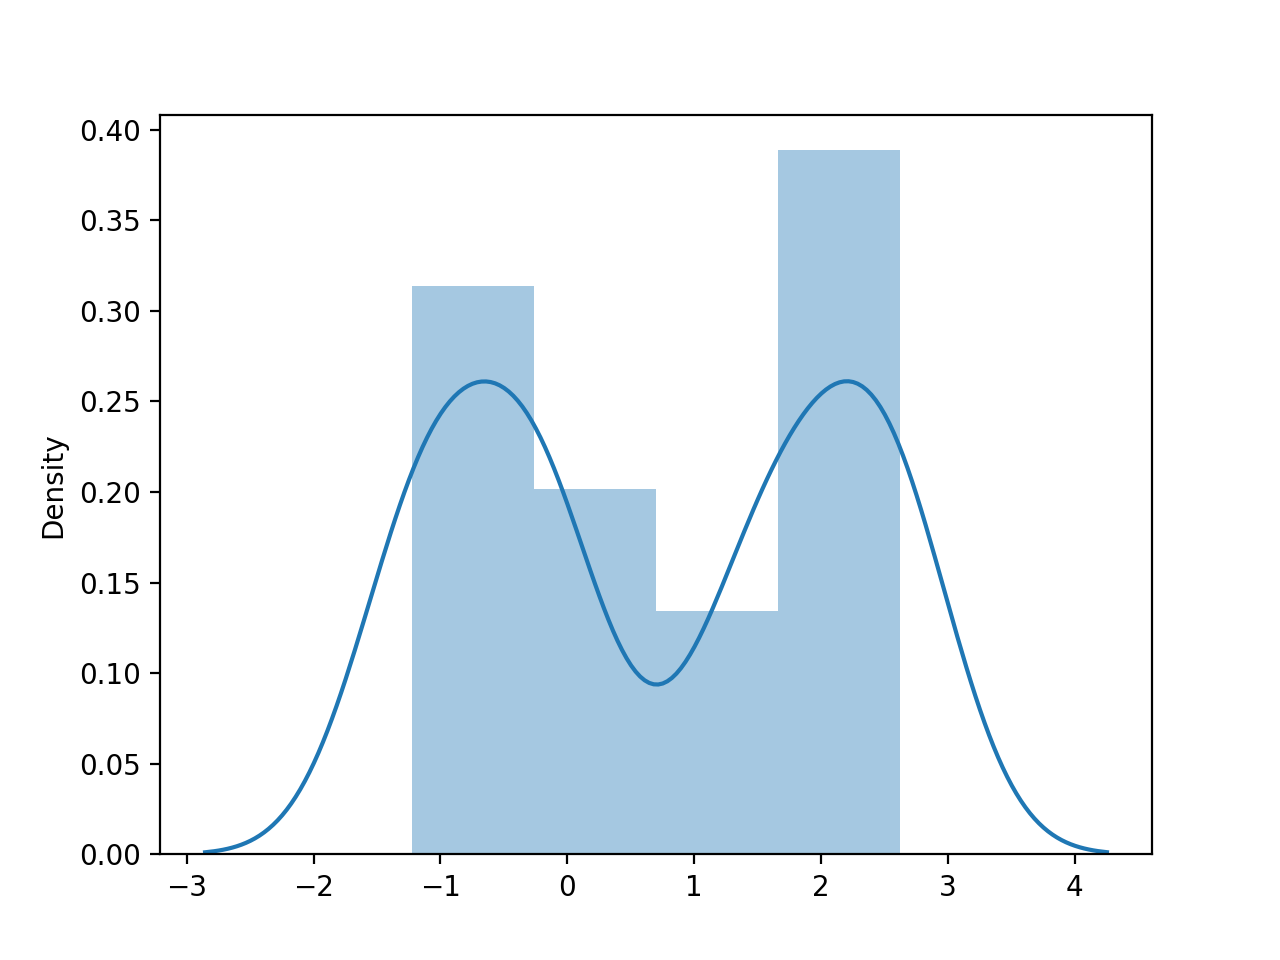

<AxesSubplot: ylabel='Density'>

In [78]:
sns.distplot(result[:input_event.size(1)].detach().cpu().numpy())

Get final result with scores and metrics

In [79]:
result = f.sigmoid(result) 

In [80]:
result

tensor([0.9287, 0.9301, 0.9274, 0.9273, 0.9268, 0.9256, 0.9324, 0.9298, 0.9261,
        0.9255, 0.9305, 0.9261, 0.9233, 0.9260, 0.9248, 0.9258, 0.9245, 0.9235,
        0.9172, 0.9244, 0.9231, 0.9320, 0.9247, 0.9216, 0.9237, 0.9259, 0.9257,
        0.9231, 0.9271, 0.9257, 0.9261, 0.9279, 0.9218, 0.9256, 0.9265, 0.8344,
        0.8845, 0.8193, 0.8563, 0.8609, 0.8740, 0.8722, 0.8100, 0.8155, 0.8170,
        0.8455, 0.8409, 0.8119, 0.7921, 0.8450, 0.7777, 0.8503, 0.8028, 0.8021,
        0.8472, 0.8005, 0.7396, 0.8881, 0.7987, 0.8120, 0.8525, 0.8717, 0.8397,
        0.8713, 0.7999, 0.8577, 0.8760, 0.8922, 0.8102, 0.8050, 0.4390, 0.4632,
        0.4478, 0.4338, 0.4376, 0.4579, 0.4476, 0.4419, 0.4367, 0.4310, 0.4455,
        0.4435, 0.4373, 0.4286, 0.4356, 0.4378, 0.4436, 0.4456, 0.4412, 0.4408,
        0.4290, 0.4498, 0.4424, 0.4599, 0.4483, 0.4350, 0.4402, 0.4326, 0.4447,
        0.4429, 0.4584, 0.4262, 0.4332, 0.4207, 0.4458, 0.2688, 0.2331, 0.2471,
        0.2404, 0.2448, 0.2556, 0.2455, 

In [81]:
result = result > 0.5
result = result.to(int)[:input_event.size(1)]

In [82]:
result 

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [84]:
labels = event_y
labels

855     True
847     True
898     True
918    False
909    False
       ...  
838     True
876     True
928    False
961    False
897     True
Name: track, Length: 139, dtype: bool

In [85]:
labels.value_counts()

True     70
False    69
Name: track, dtype: int64

Точность по всему событию

In [86]:
(labels == np.array(result)).sum() / len(labels)

0.539568345323741

Точность по фейкам

In [87]:
fakes = labels < 1

In [88]:
(labels[fakes] == np.array(result)[fakes]).sum() / len(labels[fakes])

0.5362318840579711

Точность по трекам

In [89]:
(labels[~fakes] == np.array(result)[~fakes]).sum() / len(labels[~fakes])

0.5428571428571428

Общая визуализация

In [90]:
def visualize_preds_targets_3d(data_true,
                               preds,
                               axes=['x','y','z'], 
                               titleAx=['X', 'Y', 'Z'], 
                               title=None, 
                               scatter_params_true=None, 
                               scatter_params_false=None,
                               ):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    if not scatter_params_true:
        scatter_params_true = {}
    if not scatter_params_false:
        scatter_params_true = {}
    data_true['label'] = (data['track']!=-1).astype('int')
    true_els = data_true[data_true['label']==preds]
    false_els = data_true[data_true['label']!=preds]
    ax.scatter(true_els[axes[0]], true_els[axes[1]],true_els[axes[2]], **scatter_params_true)
    ax.scatter(false_els[axes[0]], false_els[axes[1]], false_els[axes[2]], **scatter_params_false)
    
    ax.set_xlabel(titleAx[0])
    ax.set_ylabel(titleAx[1])
    ax.set_zlabel(titleAx[2])
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


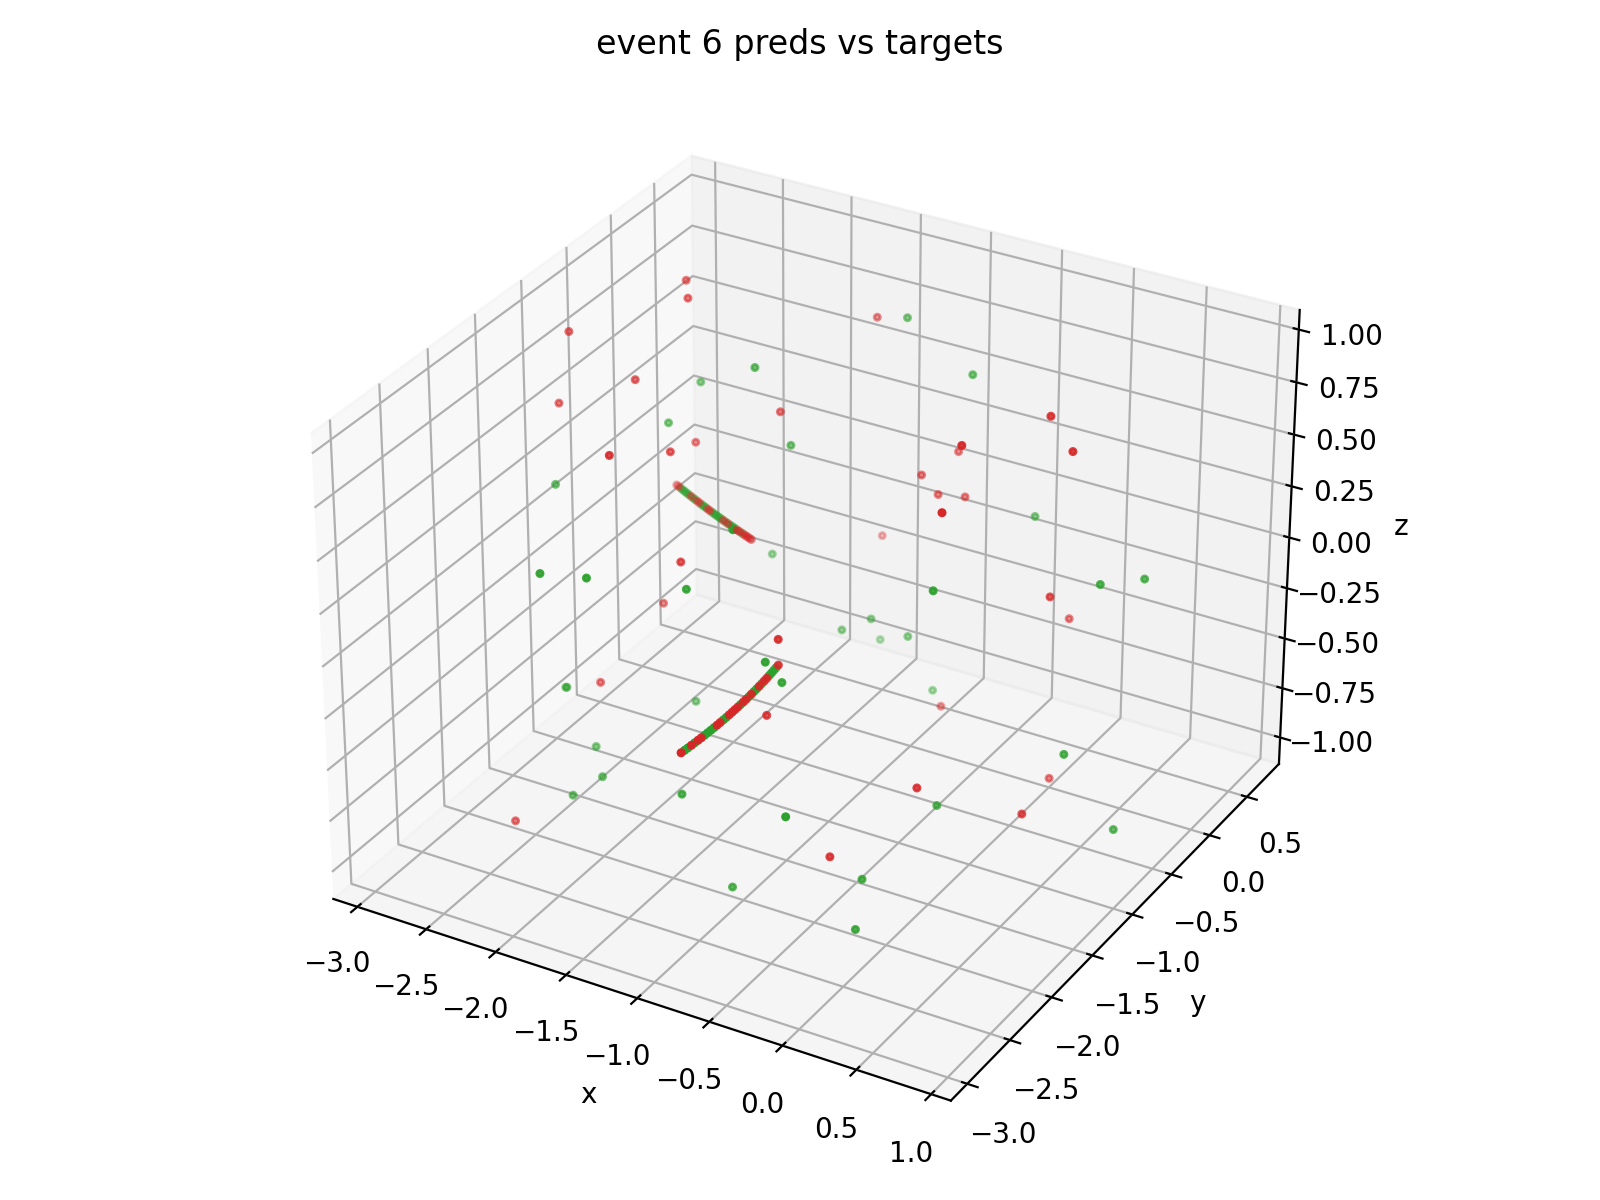

In [91]:
visualize_preds_targets_3d(event_t, np.array(result), title='event 6 preds vs targets', scatter_params_true={'c':'tab:green', 's':5}, scatter_params_false={'c':'tab:red', 's':5}, axes=['x', 'y', 'z'], titleAx=['x', 'y', 'z'])

In [95]:
def get_results_for_event(event_num=3):
    event = data[data.event == event_num]
    transforms = trn.Compose([
        trn.ConstraintsNormalize(use_global_constraints = True, columns=('x', 'y', 'z'), constraints = {
        'x': [0., 600.], 'y': [0, 600.], 'z': [-2386., 2386.]
    })])
    event_t = transforms(event)
    event_x = event_t[['x', 'y', 'z']].values.T #(event_t[['r', 'phi', 'z']].values / [1., np.pi, 1.]).T
    event_y = event_t[event_t['track'] != -1]
    input_event = torch.from_numpy(np.swapaxes(event_x, -1, -2)).unsqueeze(0).float()
    event_changed = torch.zeros((input_event.size(0), 512, input_event.size(2)))
    event_changed[:, :input_event.size(1), :input_event.size(2) ] = input_event
    mask = torch.zeros((input_event.size(0), 512), dtype=torch.bool)
    mask[:input_event.size(1)] = 1
    inputs = {'x': event_changed, 'mask': mask }
    result = model(x=inputs['x'], mask=inputs['mask'] )
    result = result.squeeze()
    result = f.sigmoid(result) > 0.5
    result = result.to(int)[:input_event.size(1)]
    labels = (event['track']!=-1).astype('int')
    print(f"Accuracy is {(labels == np.array(result)).sum() / len(labels)} ")
    print(f"Precision is {(labels[labels>0.5] == np.array(result)[labels>0.5]).sum() / np.array(result).sum()} ")
    print(f"Recall is {(labels[labels>0.5] == np.array(result)[labels>0.5]).sum() / labels.sum()} ")
    visualize_preds_targets_3d(event_t, np.array(result), title=f'event {event_num} preds vs targets', scatter_params_true={'c':'tab:green', 's':5}, scatter_params_false={'c':'tab:red', 's':5}, axes=['x', 'y', 'z'], titleAx=['x', 'y', 'z'])

Accuracy is 0.9 
Precision is 1.0 
Recall is 0.8920634920634921 


<IPython.core.display.Javascript object>


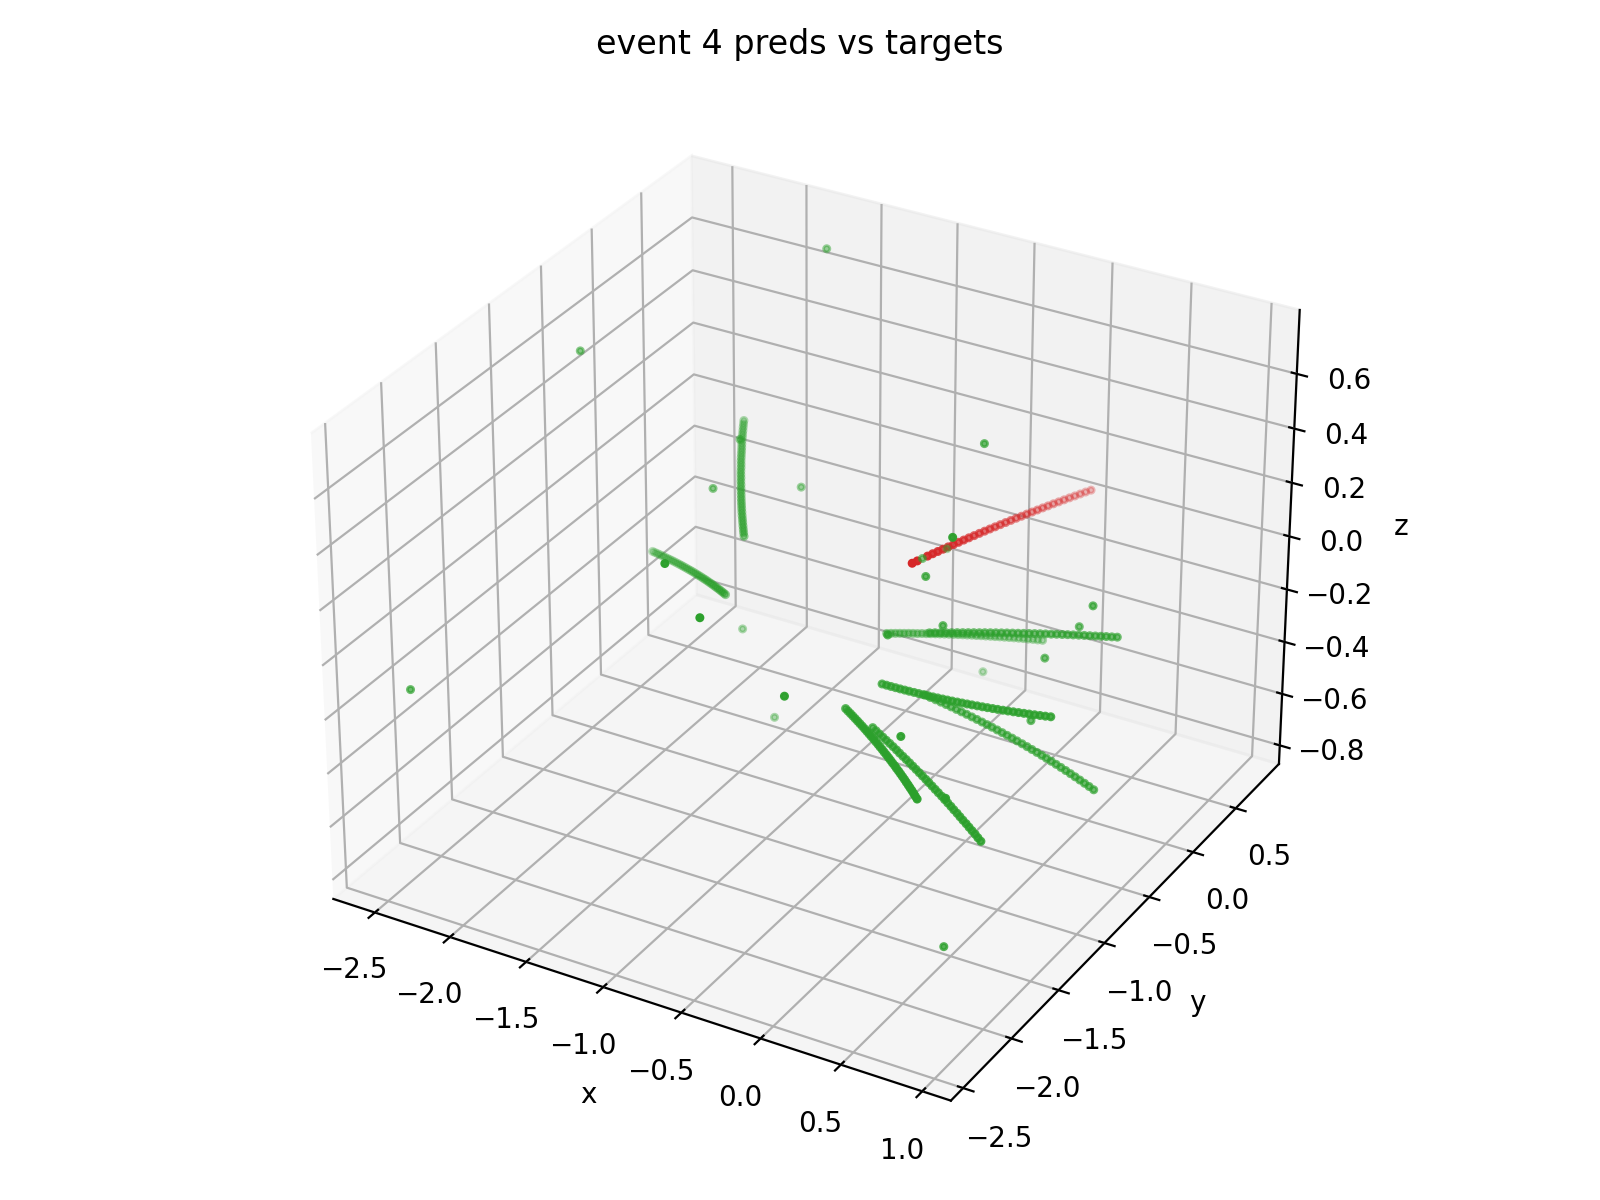

In [97]:
get_results_for_event(4)

Accuracy is 1.0 
Precision is 1.0 
Recall is 1.0 


<IPython.core.display.Javascript object>


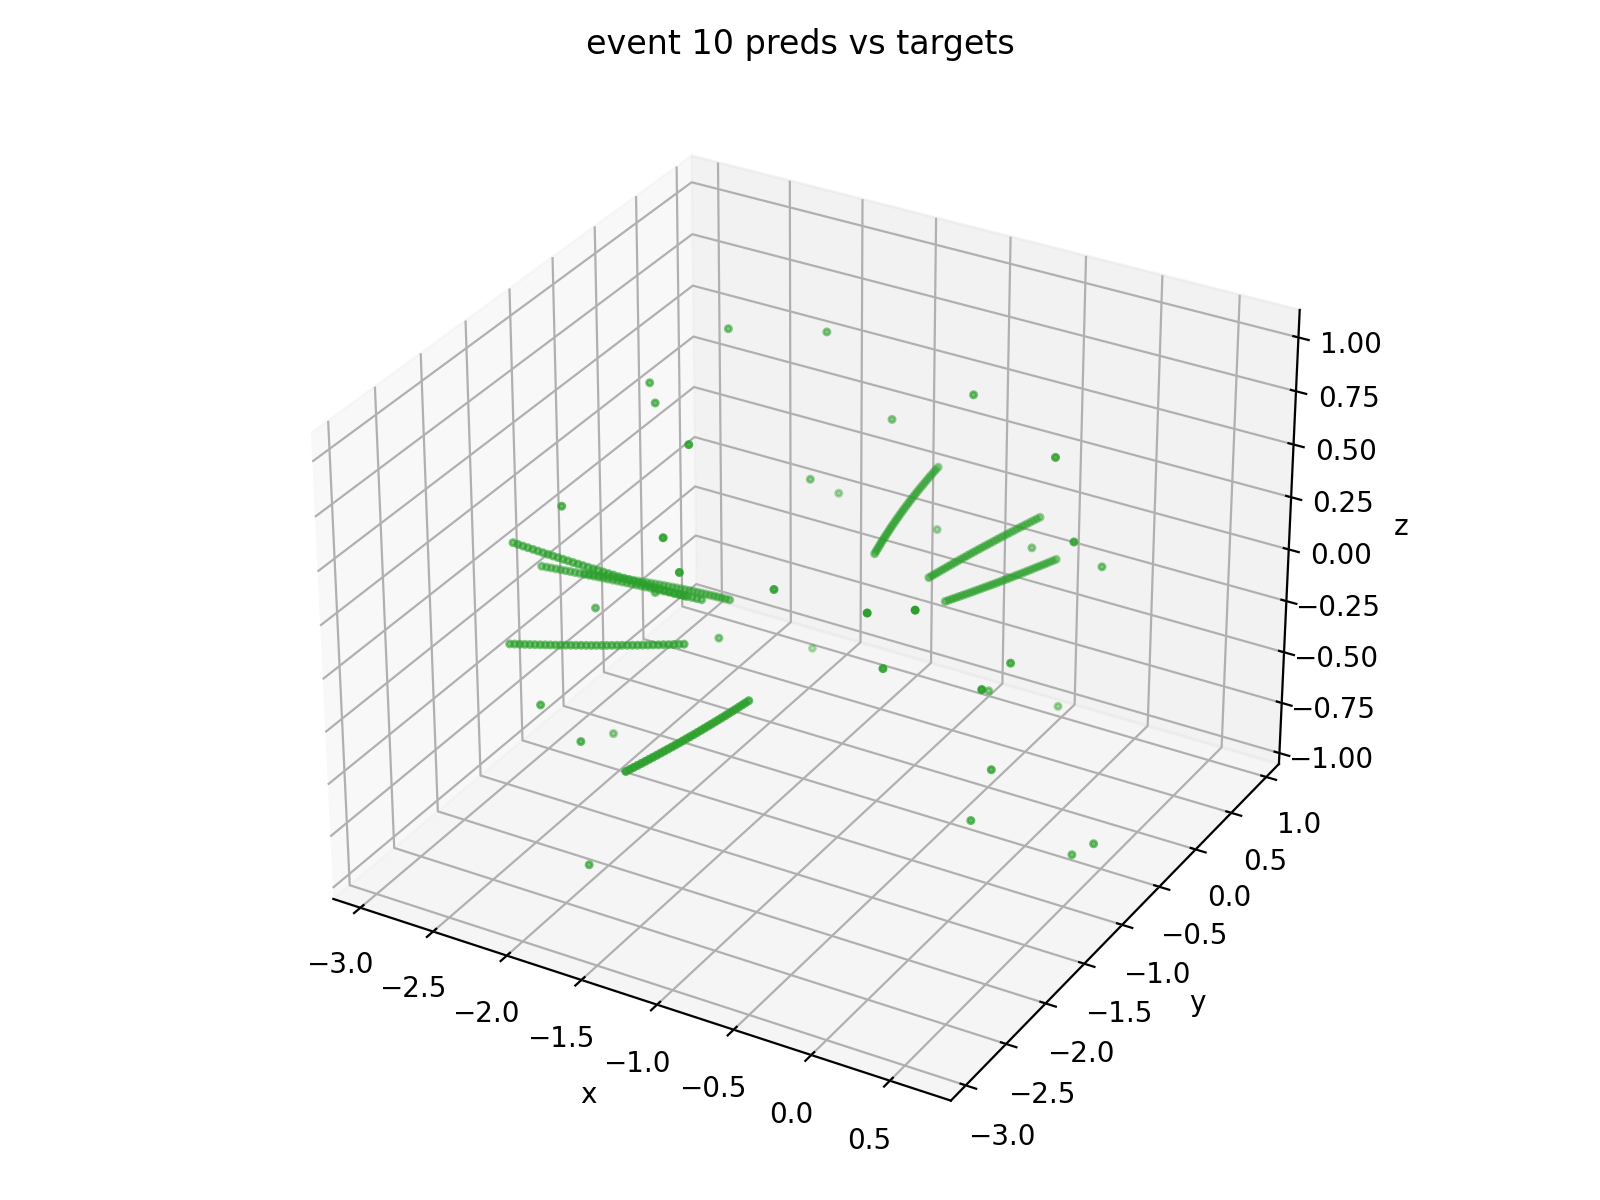

In [98]:
get_results_for_event(10)

Accuracy is 1.0 
Precision is 1.0 
Recall is 1.0 


<IPython.core.display.Javascript object>


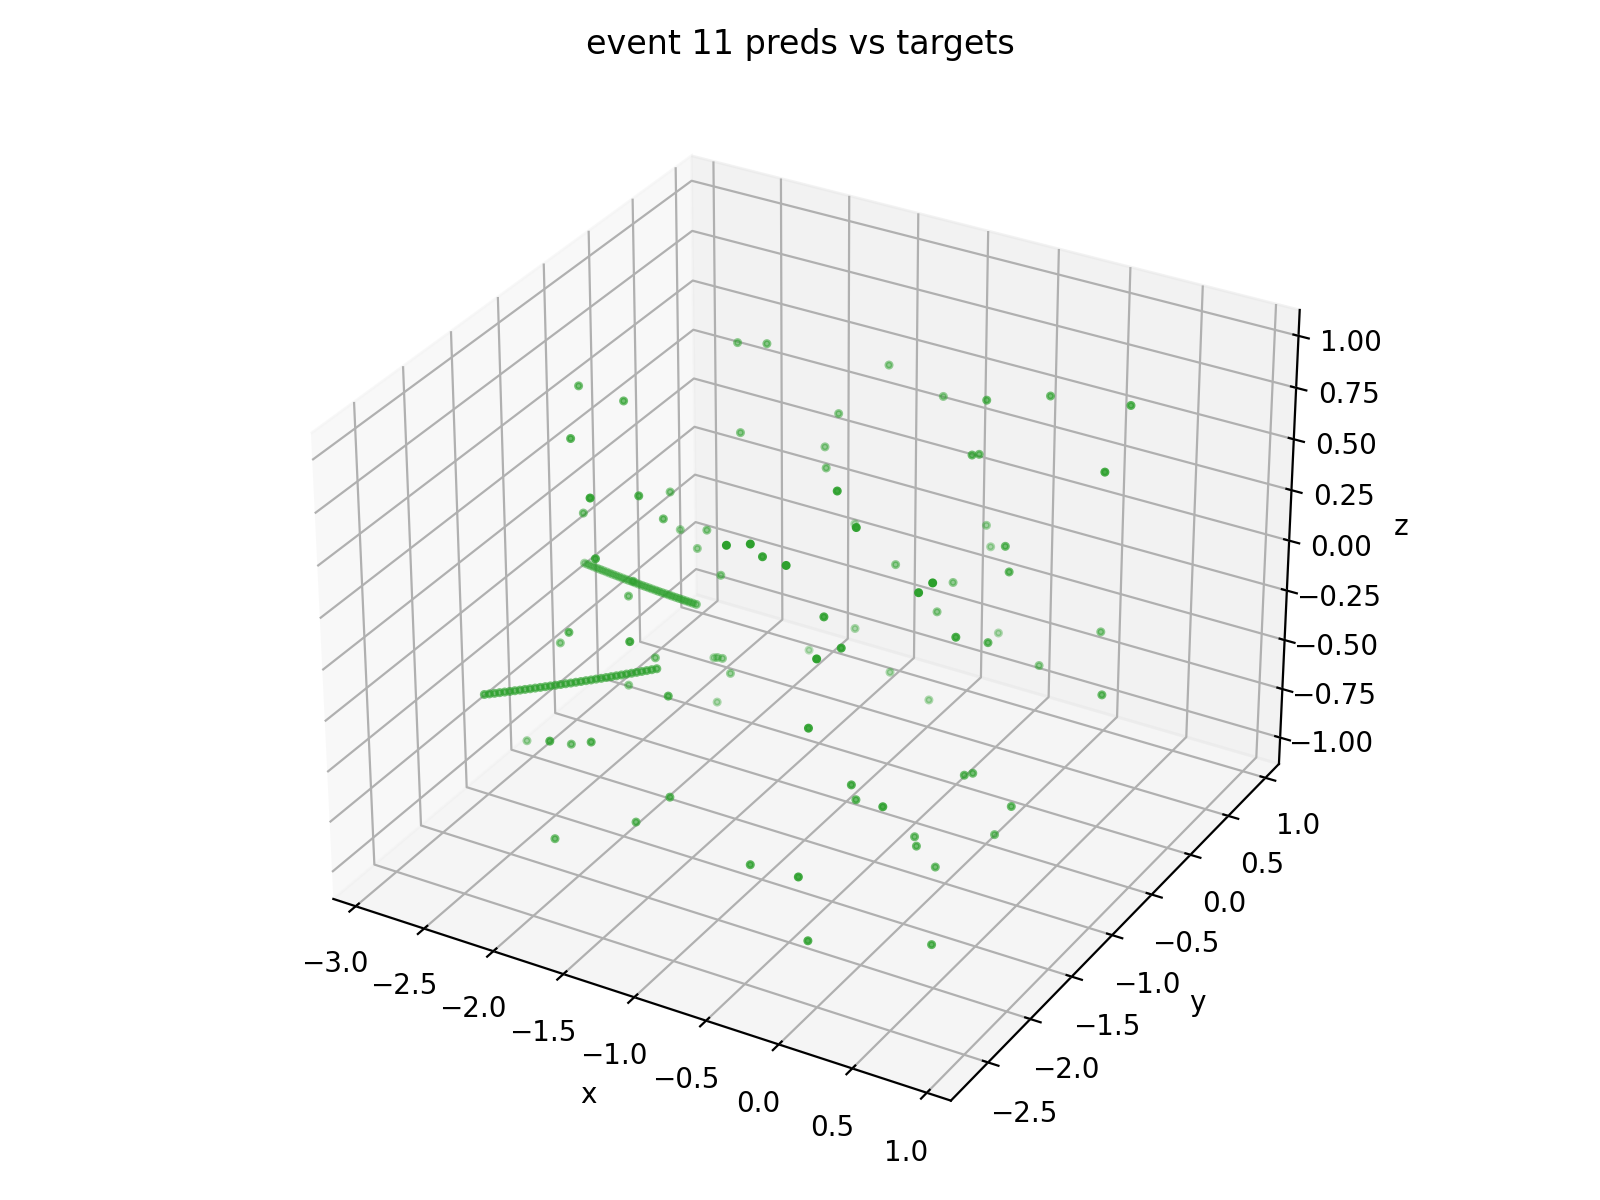

In [100]:
get_results_for_event(11)